In [1]:
using JuMP, Plots, CPLEX
import Dualization
import SCS

In [13]:
x_value = 0.5
y_value = 20

20

In [4]:
m = Model(CPLEX.Optimizer)
@variable(m, gamma_x)
@variable(m, gamma_y)
@variable(m, gamma_0)
@variable(m,a>=0)
@variable(m,b>=0)
@variable(m,c>=0)
@variable(m,d>=0)
@variable(m,mu_0>=0)
@variable(m,nu_0>=0)
@objective(m, Min, gamma_x*x_value + gamma_y*y_value - gamma_0)
@constraint(m, gamma_x == a-100*b-mu_0+c-d)
@constraint(m, gamma_y == a+b)
@constraint(m, gamma_x == a-100*b+nu_0+c-d)
@constraint(m, gamma_0 == a-b-d)
@constraint(m, gamma_0 == a-b+nu_0-d)

gamma_0 - a + b + d - nu_0 == 0

In [5]:
optimize!(m)

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Dual infeasible due to empty column 'x1'.
Presolve time = 0.00 sec. (0.00 ticks)


In [6]:
objective_value(m)

MathOptInterface.ResultIndexBoundsError{MathOptInterface.ObjectiveValue}: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.

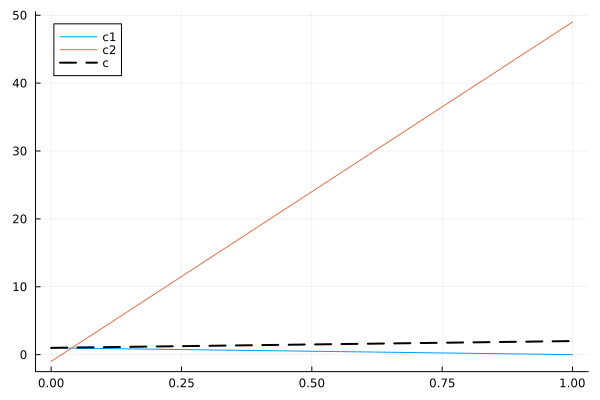

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 0 columns.
Reduced LP has 2 rows, 2 columns, and 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             0.000000
Iteration:     2   Dual objective     =             1.000000
γ0 = 1.0
γ = [-1.0, 1.0]
[0.0 1.0]
[0.0 0.0]
-1.0
0.0
objective_value = -0.07843137254901958


In [75]:
function run_example(k,M)
    coef1 = [1,-50,1,-1]
    coef2 = [1,1,0,0]
    rhs = [1,-1,0,-1]
    len = length(coef1)
    x = range(0, 1, length=100)

    p = plot()
    for i in 1:2
        y = (rhs[i] .- coef1[i].*x) ./ coef2[i]
        p = plot!(x, y, label="c$i")
    end
    # p = plot!(ones(100), range(0, 2, length=100), label="c4")
    # p = plot!(range(0, 1, length=100), ones(100), label="c5")
    # p = plot!(zeros(100), range(0, 2, length=100), label="c6")
    # p = plot!(range(0, 1, length=100), zeros(100), label="c7")
    m = Model(CPLEX.Optimizer)
    @variable(m, x1)
    @variable(m, x2)
    @constraint(m, [i in 1:len], coef1[i]*x1 + coef2[i]*x2 >= rhs[i])
    @objective(m, Min, x1 + x2)
    optimize!(m)
    A = [coef1 coef2]
    CGLP = Model(CPLEX.Optimizer)
    set_attribute(CGLP, MOI.Silent(), true)
    # CGLP = Model(SCS.Optimizer)
    set_optimizer_attribute(CGLP, "CPX_PARAM_EPRHS", 1e-9)
    set_optimizer_attribute(CGLP, "CPX_PARAM_EPOPT", 1e-9)
    @variable(CGLP, u[1:len]>=0)
    @variable(CGLP, v[1:len]>=0)
    @variable(CGLP, u0>=0)
    @variable(CGLP, v0>=0)
    @variable(CGLP, γ0)
    @variable(CGLP, γ[1:2])
    @variable(CGLP, t)
    
    x̂ = [2/51,49/51]
    # x̂ = [0.49,1]
    pis = [1 0]

    @objective(CGLP, Min, sum(γ[i]*x̂[i] for i in 1:2) - γ0)
    @constraint(CGLP, con1, γ' .== u'A .- u0.*pis)
    @constraint(CGLP, con2, γ' .== v'A .+ v0.*pis)
    @constraint(CGLP, con3, γ0 .== u'rhs - 0*u0)
    @constraint(CGLP, con4, γ0 .== v'rhs .+ 1*v0)
    # @constraint(CGLP, γ0 .== u'rhs )
    # @constraint(CGLP, γ0 .== v'rhs .+ v0)
    # @constraint(CGLP, sum(u[i] for i in 1:len) + M*u0 + sum(v[i] for i in 1:len) + M*v0 == 1)
    # @constraint(CGLP, M*u0 + v0 == 1)
    # @constraint(CGLP, [t; γ] in MOI.NormOneCone(3))
    # @constraint(CGLP, [t; γ] in MOI.SecondOrderCone(3))
    @constraint(CGLP, [t; γ] in MOI.NormInfinityCone(3))
    @constraint(CGLP, t == 1)
    # @constraint(CGLP, [γ; 1] in MOI.NormOneCone(3))

    
    optimize!(CGLP)
    # println("u = ", value.(u))
    # println("v = ", value.(v))
    # println("u0 = ", value(u0))
    # println("v0 = ", value(v0))
    println("γ0 = ", value(γ0))
    println("γ = ", value.(γ))
    print(dual.(con1), "\n", dual.(con2), "\n", dual.(con3), "\n", dual.(con4), "\n")
    println("objective_value = ", objective_value(CGLP))
    if value.(γ)[2] != 0
        p = plot!(x, (value(γ0) .- value.(γ)[1] .*x) ./ value.(γ)[2], label="c", linestyle=:dash, color = :black, linewidth=2)
    else
        p = plot!(ones(100)*value(γ0) / value.(γ)[1], x, label="c", linestyle=:dash, color = :black, linewidth=2)
    end
    display(p)
end
run_example(1,1)

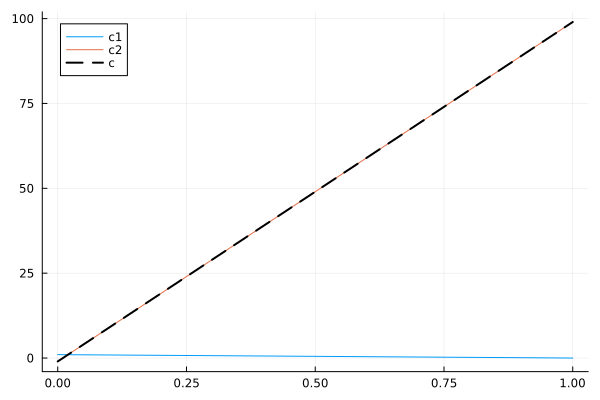

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 0 columns.
Reduced LP has 2 rows, 2 columns, and 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             0.000000
Iteration:     2   Dual objective     =             1.000000
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 5 rows, 12 columns, and 26 nonzeros.
Presolve time = 0.00 sec. (0.01 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Scaled dual infeas =             0.000000
Iteration:     2   Dual objective     =

In [15]:
run_example(1,1)  #k=1, M=1(M is set like you said)
# cut 1 shown in the paper

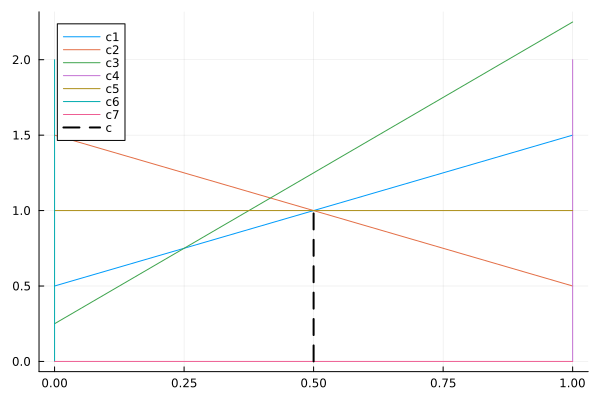

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 0 columns.
Reduced LP has 3 rows, 2 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =            -2.500000
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 5 rows, 18 columns, and 38 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            -0.750000
u = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
v = [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -0.0]
u0 = 1.0
v0 = 1.0
γ

In [196]:
run_example(8,1)  #k=8, M=1(M is set like you said)
# cut 3 shown in the paper

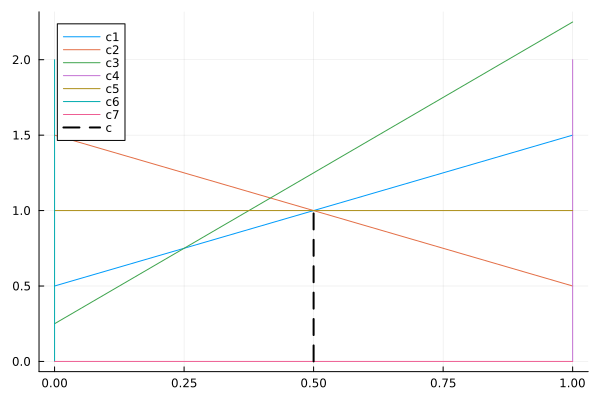

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 0 columns.
Reduced LP has 3 rows, 2 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =            -2.500000
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 5 rows, 18 columns, and 38 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            -1.000000
u = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
v = [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -0.0]
u0 = 1.0
v0 = 1.0
γ

In [197]:
run_example(1,1e-06)  #k=1, M=1(M is set like you said)
# cut 2 shown in the paper
# which means that we could find the optimal cut by adjusting weight of u0 and v0

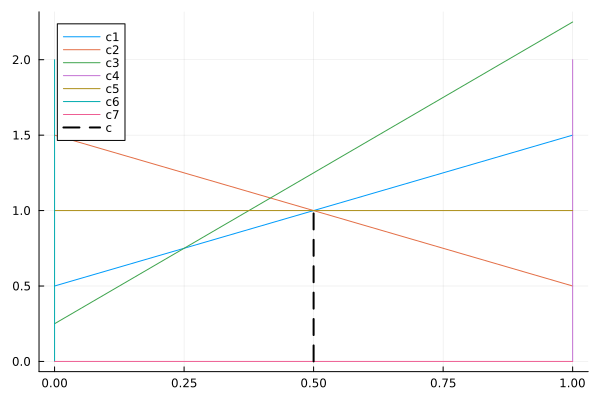

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
LP Presolve eliminated 4 rows and 0 columns.
Reduced LP has 3 rows, 2 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =            -2.500000
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 5 rows, 18 columns, and 38 nonzeros.
Presolve time = 0.00 sec. (0.02 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            -0.750000
u = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
v = [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -0.0]
u0 = 1.0
v0 = 1.0
γ

In [198]:
run_example(8,1e-06)  #k=8, M=1(M is set like you said)
# a new cut not shown in the paper
# when k is large, the optimal cut is not unique